In [1]:
import pandas as pd 

# read the raw dataset and display few rows
raw_data = pd.read_csv('conversion_project.csv')

#display(raw_data)
raw_data.head(5)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [2]:
raw_data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [5]:
raw_data.groupby('country').size()

country
China       76602
Germany     13056
UK          48450
US         178092
dtype: int64

In [6]:
raw_data.groupby('new_user').size()

new_user
0     99456
1    216744
dtype: int64

In [7]:
raw_data.groupby('source').size()

source
Ads        88740
Direct     72420
Seo       155040
dtype: int64

In [9]:
raw_data.groupby('converted').size()

converted
0    306000
1     10200
dtype: int64

In [11]:
display(raw_data)

## better if I can find some method to display all columns with the data type

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0
...,...,...,...,...,...,...
316195,US,26,1,Ads,9,0
316196,US,27,1,Direct,6,0
316197,China,25,0,Ads,4,0
316198,US,22,0,Seo,4,0


In [3]:
## the max value of age doesn't make sense. 
## let's get all values of age to see what is wrong

## add the * in front of list to print the line in one line

print(*sorted(raw_data['age'].unique(), reverse=True))

123 111 79 77 73 72 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17


In [4]:
# check the data with age 123 and 111

raw_data[raw_data['age']>110]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [5]:
# there are only 2 records with non-sense age info
# so we can simply delete them

data1 = raw_data[raw_data['age']<110]

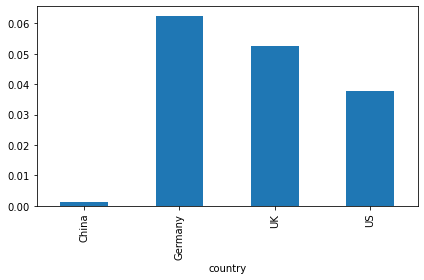

In [6]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
  
data1.groupby(['country'])['converted'].mean().plot.bar()
plt.show()

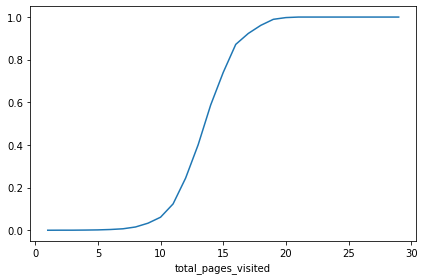

In [14]:
# the click from the country China has lowest conversion rate
# check more attributes
# the total number of pages that user visited

data1.groupby(['total_pages_visited'])['converted'].mean().plot()
plt.show()

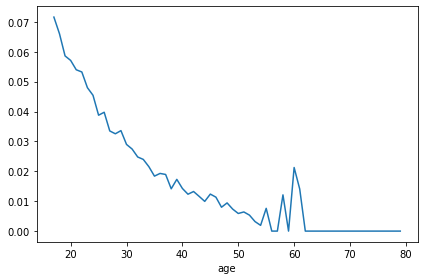

In [8]:
# it makes sense that more pages visited, higher chance converted
# check if conversion rate is dependent on age

data1.groupby(['age'])['converted'].mean().plot()
plt.show()

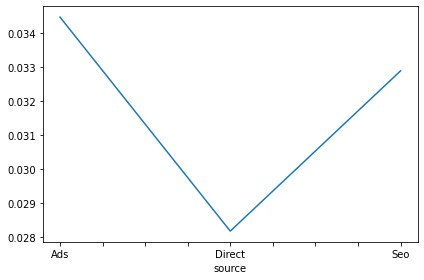

In [15]:
# overall, we can see the trend of younger user, higher conversion rate
# check if source has something to do with the rate

data1.groupby(['source'])['converted'].mean().plot()
plt.show()

In [16]:
# binary prediction on if converted
# we can choose 1, logistic regression; 2, random forest

# logistic regress first

# first, change the categorical attributes to dummy
data1_dummy = pd.get_dummies(data1, drop_first=True)

In [18]:
# random forest

import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

np.random.seed(4684)

train, test = train_test_split(data1_dummy, test_size=0.34)

rdfr = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rdfr.fit(train.drop('converted', axis=1), train['converted'])

print('OOB accuracy is ', rdfr.oob_score_)
print('OOB confusion matrix \n', pd.DataFrame(confusion_matrix(train['converted'], rdfr.oob_decision_function_[:,1].round(), labels=[0, 1])))




OOB accuracy is  0.9838851885571901
OOB confusion matrix 
         0     1
0  200872  1102
1    2261  4455


In [24]:
# OOB means out of bag, using part of DTs that don't use the left-over sample to calculate the score
# it is different from the validataion score:
#       1, using training dataset vs test dataset
#       2, subset of DTs vs full ensemble random forest

# let's check how it works on the test data
rdfr.score
print("Test accuracy is", rdfr.score(test.drop(['converted'], axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['converted'], rdfr.predict(test.drop('converted', axis=1)), labels=[0, 1])))

Test accuracy is 0.9847360196450496 
 Test Set Confusion Matrix 
         0     1
0  103483   543
1    1098  2384


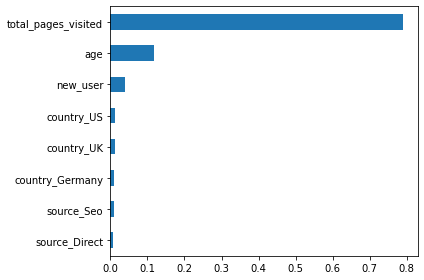

In [25]:
# check the variable importance

feat_importances = pd.Series(rdfr.feature_importances_, index=train.drop('converted', axis=1).columns)
feat_importances.sort_values().plot(kind='barh')
plt.show()

In [26]:
# what if we don't build the model on 'total_pages_visited' since this one is hardly to manipulate

# class_weight try to balance the heavily unbalanced data
# value 0 with weight 1; and value 1 with weight 10

rdfr2 = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True, class_weight={0:1, 1:10})
rdfr2.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])
  
print(
"OOB accuracy is", 
rdfr2.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(train['converted'], rdfr2.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.889827016148354 
 OOB Confusion Matrix 
         0      1
0  182720  19254
1    3738   2978


In [27]:
print(
"Test accuracy is", rdfr2.score(test.drop(['converted', 'total_pages_visited'], axis=1),test['converted']), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(test['converted'], rdfr2.predict(test.drop(['converted', 'total_pages_visited'], axis=1)), labels=[0, 1]))
)

Test accuracy is 0.8899802805372623 
 Test Set Confusion Matrix 
        0     1
0  94140  9886
1   1942  1540


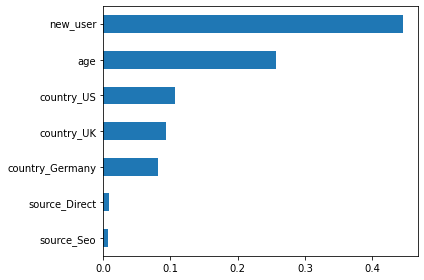

In [28]:
feat_importances2 = pd.Series(rdfr2.feature_importances_, index=train.drop(['converted', 'total_pages_visited'], axis=1).columns)
feat_importances2.sort_values().plot(kind='barh')
plt.show()

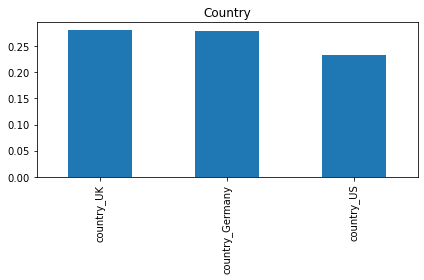

In [31]:
# partial dependence plots

from pdpbox import pdp, info_plots
# country
pdp_iso = pdp.pdp_isolate( model=rdfr2, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['country_Germany', 'country_UK', 'country_US'], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Country')
plt.show()

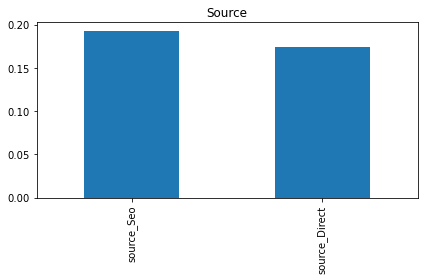

In [32]:
# source
pdp_iso = pdp.pdp_isolate( model=rdfr2, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature=['source_Direct', 'source_Seo'], 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='Source')
plt.show()

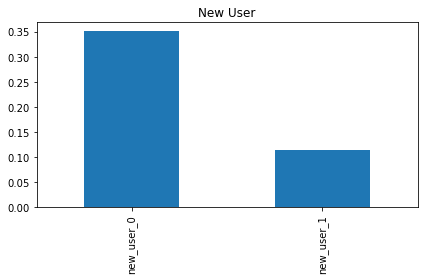

In [34]:
# if new_user
pdp_iso = pdp.pdp_isolate( model=rdfr2, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='new_user', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='New User')
plt.show()

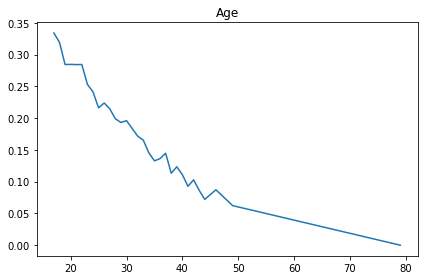

In [37]:
# age
pdp_iso = pdp.pdp_isolate( model=rdfr2, 
                          dataset=train.drop(['converted', 'total_pages_visited'], axis=1),      
                          model_features=list(train.drop(['converted', 'total_pages_visited'], axis=1)), 
                          feature='age', 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.feature_grids)
pdp_dataset.plot(title='Age')
plt.show()

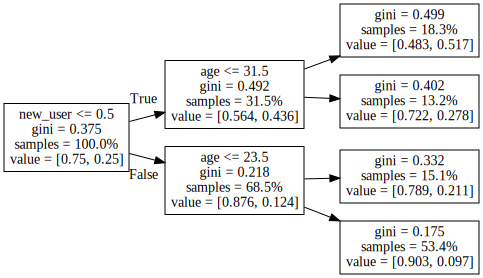

In [43]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source

tree = DecisionTreeClassifier( max_depth=2,class_weight={0:1, 1:10}, min_impurity_decrease = 0.001)
tree.fit(train.drop(['converted', 'total_pages_visited'], axis=1), train['converted'])
  
#visualize it
export_graphviz(tree, out_file="tree_conversion.dot", feature_names=train.drop(['converted', 'total_pages_visited'], axis=1).columns, proportion=True, rotate=True)
with open("tree_conversion.dot") as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)